In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import io
import os
import re
import string
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

In [3]:
BATCH_SIZE=32
LR=1e-4
FRAME_LENGTH=255  ### The length of each frame in seconds.
FRAME_STEP=128    ###  The step between successive frame in seconds.
N_EPOCHS=10

In [4]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

--2024-05-22 05:16:17--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 24.199.73.137
Connecting to data.keithito.com (data.keithito.com)|24.199.73.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [text/plain]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  70.6MB/s    in 42s     

2024-05-22 05:16:59 (62.0 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [5]:
!mkdir "/content/dataset/"
!tar -xjvf "/content/LJSpeech-1.1.tar.bz2" -C "/content/dataset/"

Streaming output truncated to the last 5000 lines.
LJSpeech-1.1/wavs/LJ022-0089.wav
LJSpeech-1.1/wavs/LJ030-0192.wav
LJSpeech-1.1/wavs/LJ041-0078.wav
LJSpeech-1.1/wavs/LJ045-0249.wav
LJSpeech-1.1/wavs/LJ034-0035.wav
LJSpeech-1.1/wavs/LJ010-0152.wav
LJSpeech-1.1/wavs/LJ036-0174.wav
LJSpeech-1.1/wavs/LJ035-0076.wav
LJSpeech-1.1/wavs/LJ032-0176.wav
LJSpeech-1.1/wavs/LJ046-0113.wav
LJSpeech-1.1/wavs/LJ017-0096.wav
LJSpeech-1.1/wavs/LJ004-0098.wav
LJSpeech-1.1/wavs/LJ010-0147.wav
LJSpeech-1.1/wavs/LJ042-0230.wav
LJSpeech-1.1/wavs/LJ041-0033.wav
LJSpeech-1.1/wavs/LJ045-0229.wav
LJSpeech-1.1/wavs/LJ014-0199.wav
LJSpeech-1.1/wavs/LJ002-0082.wav
LJSpeech-1.1/wavs/LJ006-0055.wav
LJSpeech-1.1/wavs/LJ045-0120.wav
LJSpeech-1.1/wavs/LJ050-0028.wav
LJSpeech-1.1/wavs/LJ045-0215.wav
LJSpeech-1.1/wavs/LJ013-0121.wav
LJSpeech-1.1/wavs/LJ008-0025.wav
LJSpeech-1.1/wavs/LJ005-0240.wav
LJSpeech-1.1/wavs/LJ044-0026.wav
LJSpeech-1.1/wavs/LJ048-0127.wav
LJSpeech-1.1/wavs/LJ006-0195.wav
LJSpeech-1.1/wavs/LJ030-0

In [6]:
audio_binary=tf.io.read_file("/content/dataset/LJSpeech-1.1/wavs/LJ001-0001.wav")
audio,_=tf.audio.decode_wav(audio_binary)  ##Decode a 16-bit PCM WAV file to a float tensor.
waveform=tf.squeeze(audio,axis=-1)
waveform=tf.cast(waveform,tf.float32)
signal=waveform
print(signal.shape)

(212893,)


(212893,)


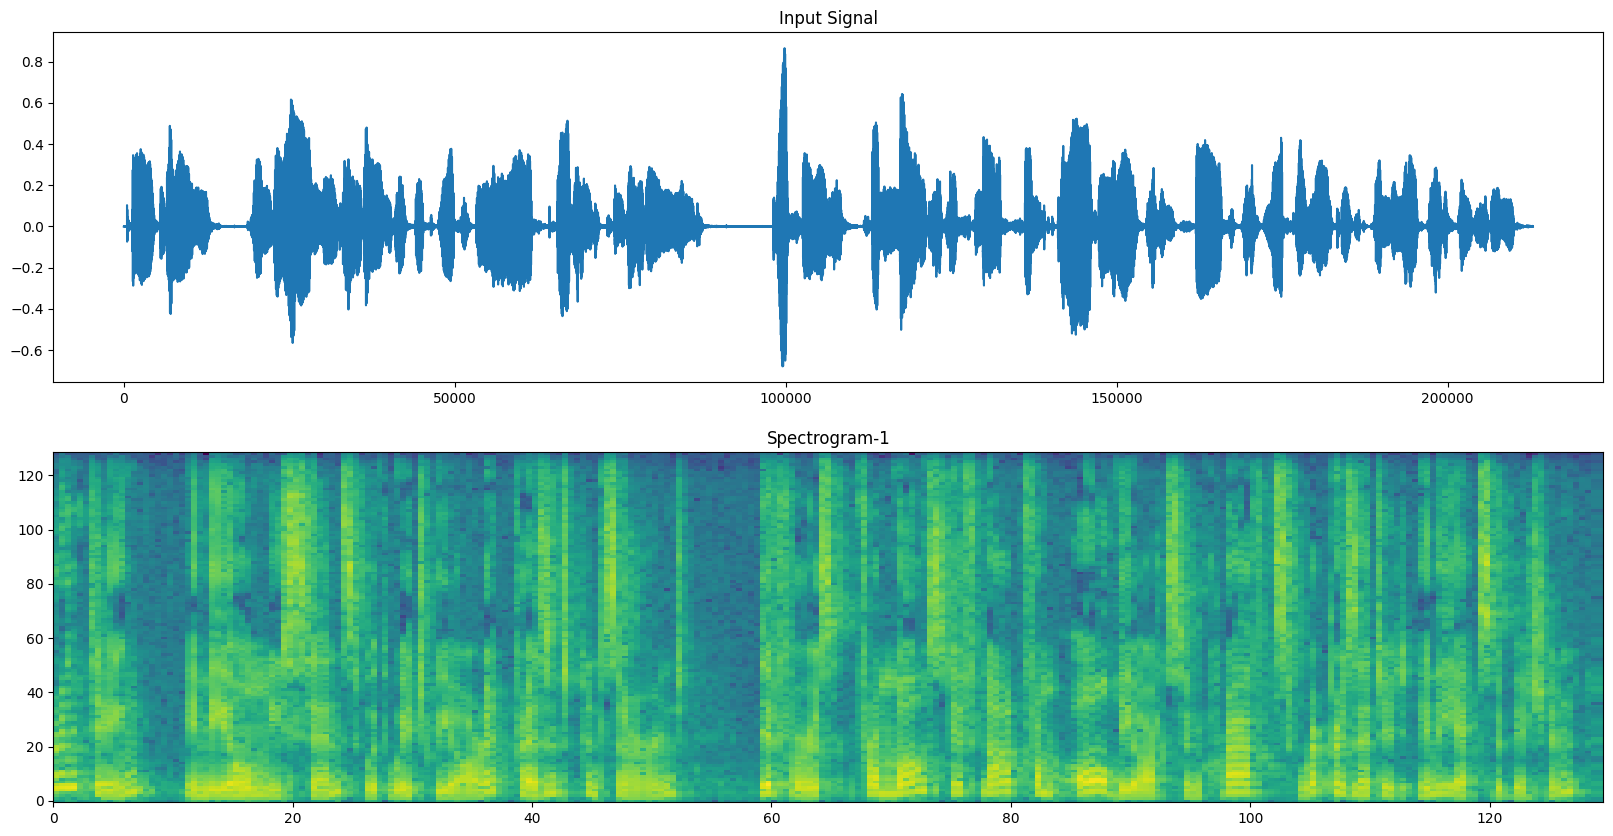

In [7]:
fig,axis=plt.subplots(2,figsize=(20,10))

L=2000
x=tf.linspace(-L//2,L//2,L)
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")


spec=tf.signal.stft(signal,frame_length=256,frame_step=512,)
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[1].pcolormesh(X,Y,power_spec)
axis[1].set_title("Spectrogram-1")


plt.show()

In [33]:
audio_text={}

csv_path="/content/dataset/LJSpeech-1.1/metadata.csv"
with open(csv_path, encoding="utf-8") as f:
  for line in f:
    i=line.strip().split("|")[0]
    text=line.strip().split("|")[1]
    audio_text[str(i)]=text

In [34]:
audio_text

{'LJ001-0001': 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition',
 'LJ001-0002': 'in being comparatively modern.',
 'LJ001-0003': 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process',
 'LJ001-0004': 'produced the block books, which were the immediate predecessors of the true printed book,',
 'LJ001-0005': 'the invention of movable metal letters in the middle of the fifteenth century may justly be considered as the invention of the art of printing.',
 'LJ001-0006': 'And it is worth mention in passing that, as an example of fine typography,',
 'LJ001-0007': 'the earliest book printed with movable types, the Gutenberg, or "forty-two line Bible" of about 1455,',
 'LJ001-0008': 'has never been surpassed.',
 'LJ001-0009': 'Printing, then, for our purpose, may be considered as the art of

### Whisper Huggingface model

In [8]:
pip install transformers torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [10]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00


In [11]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset

In [12]:
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
model.config.forced_decoder_ids = None

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

In [23]:
ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for hf-internal-testing/librispeech_asr_dummy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hf-internal-testing/librispeech_asr_dummy
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [24]:
ds[0]

{'file': '/root/.cache/huggingface/datasets/downloads/extracted/dfbece23564f422bc5794f3090902cd16d52d86767b746125ebc2ff3ea5f89ef/dev_clean/1272/128104/1272-128104-0000.flac',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/dfbece23564f422bc5794f3090902cd16d52d86767b746125ebc2ff3ea5f89ef/dev_clean/1272/128104/1272-128104-0000.flac',
  'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
         0.0010376 ]),
  'sampling_rate': 16000},
 'text': 'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL',
 'speaker_id': 1272,
 'chapter_id': 128104,
 'id': '1272-128104-0000'}

In [25]:
sample = ds[0]["audio"]

In [26]:
input_features = processor(sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt").input_features

In [27]:
predicted_ids = model.generate(input_features)
# decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)

In [28]:
transcription

[' Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.']

### Test model over LJSpeech dataset

In [29]:
signal

<tf.Tensor: shape=(212893,), dtype=float32, numpy=
array([-7.3242188e-04, -7.6293945e-04, -6.4086914e-04, ...,
        7.3242188e-04,  2.1362305e-04,  6.1035156e-05], dtype=float32)>

In [30]:
input_features = processor(signal, sampling_rate=16000, return_tensors="pt").input_features

In [31]:
predicted_ids = model.generate(input_features)
# decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)

In [32]:
transcription

[' Printing, in the only sense with which we are at present concerned, differs from most, if not from all the arts and crafts represented in the exhibition.']